In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, mean_squared_error
from tensorflow.keras import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
%matplotlib inline

In [2]:
def calc_rsi(df, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = df.adj_close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
        # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [3]:
def read_data(filename):
    data = pd.read_csv(filename)
    data = data.rename(str.lower, axis=1)
    data = data.rename(mapper={'adj close': 'adj_close'}, axis=1)
    data.date = pd.to_datetime(data.date)
    data = data.set_index('date')
    return data

def add_features(df):
    # accumulation/Distribution line
    mult = ((df.close - df.low) - (df.high - df.close)) / (df.high - df.low)
    MFVolume = mult * df.volume
    accum_dist_indicator = MFVolume.cumsum()
    ret_df = pd.concat([df, accum_dist_indicator], axis=1)
    ret_df = ret_df.rename(mapper={0:'accum_dist_indicator'}, axis=1)
    
    #MACD
    EMA_12 = df.adj_close.ewm(span=12, adjust=False).mean()
    EMA_26 = df.adj_close.ewm(span=26, adjust=False).mean()
    macd = EMA_12 - EMA_26
    signal = macd.ewm(span=9, adjust=False).mean()
    ret_df = pd.concat([ret_df, macd.rename('macd'), signal.rename('signal_macd')], axis=1)
    
    #RSI
    rsi = calc_rsi(df)
    ret_df = pd.concat([ret_df, rsi.rename('rsi')], axis=1)
    
    return ret_df
    
def series_to_supervised(data, n_in=1, n_out=1, col_names = [], indicies = [], preds = [], dropnan=True):
    '''
    Convert a time series to a supervised learning dataset
    Args:
        data -> time series to convert as a list or numpy array
        n_in -> number of lag observations as input (X)
        n_out -> number of observations as output (y)
        col_names -> names of the columns
        indicies -> list of the indicies
        preds -> list of column indicies to determine which variables to predict
        dropnan -> flag of whether to drop the rows with NaN
    Returns:
        Pandas DataFrame of series framed for supervised learning
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (col_names[j], i)) for j in range(n_vars)]
    # forecast sequence
    for i in range(0, n_out):
        cols.append(df[col_names[preds]].shift(-i))
        if i==0:
            names += [('%s(t)' % (col_names[j])) for j in preds]
        else:
            names += [('%s(t+%d)' % (col_names[j], i)) for j in preds]
    # putting it together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.index = indicies
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def scale(train, test):
    '''
    Rescales the train and test sets
    Args:
        train -> numpy array of the training data
        test -> numpy array of the test data
    Returns:
        scaler -> the scaler object for transforming
        train_scaled -> a rescaled version of the train data
        test_scaled -> a rescaled version of the test data
    '''
    # scale train and test to [-1,1]
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

def split_data(data, test_percent):
    '''
    Splits the data by percentage amount
    Returns: train, test
    '''
    split_val = int(len(data) * (1 - test_percent))
    train, test = data[:split_val], data[split_val:]
    return train, test

In [4]:
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
    # separate into input target
    X, y = scaled_dataset[:,:-1], scaled_dataset[:,-1]
    # reshape
    reshaped = X.reshape(len(X), 1, -1)
    # forecast dataset
    output = model.predict(reshaped, batch_size=batch_size, verbose=0)
    # invert transforms on the forecast
    predictions = list()
    for i in range(len(output)):
        yhat = output[i,0]
        # invert scaling
        yhat = invert_scale(scaler, X[i], yhat)
        # invert differencing
        yhat = yhat + raw_data[i][-1]
        # store the forecast
        predictions.append(yhat)
    # report performance
    rmse = np.sqrt(mean_squared_error(raw_data[1:,-1], predictions))
    return rmse

def fit_lstm(train, test, raw, scaler, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # prepare a model
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful = True))
    model.add(Dropout(.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit model
    train_rmse, test_rmse = list(), list()
    for i in range(nb_epoch):
        if not i % 10:
            print('%d/%d'%(i,nb_epoch), end='')
        else:
            print('.', end='')
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
        
        # evaluate model on training set
        raw_train = raw[-(len(train) + len(test) + 1):-len(test)]
        train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
        model.reset_states()
        
        # evaluate on the test set
        raw_test = raw[-(len(test) + 1):]
        test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
        model.reset_states()
    print()
    history = pd.DataFrame()
    history['train'], history['test'] = train_rmse, test_rmse
    return history

In [5]:
temp = np.arange(0,280)
len(temp[:-(len(temp) % 16)]) % 16

0

In [6]:
temp = read_data('../../data/SPY_1993-01-29_2022-08-17.csv')
temp = add_features(temp)
temp = series_to_supervised(temp, 14, 5, col_names=temp.columns, indicies=temp.index, preds = [4])
temp.drop(temp.columns[-5:-1], axis=1)

,open(t-14),high(t-14),low(t-14),close(t-14),adj_close(t-14),volume(t-14),accum_dist_indicator(t-14),macd(t-14),signal_macd(t-14),rsi(t-14),...,high(t-1),low(t-1),close(t-1),adj_close(t-1),volume(t-1),accum_dist_indicator(t-1),macd(t-1),signal_macd(t-1),rsi(t-1),adj_close(t+4)
date,,,,,,,,,,,,,,,,,,,,,
1993-03-11,43.406250,43.562500,43.343750,43.562500,25.220989,34900.0,2.121390e+06,-0.046298,0.042307,36.183857,...,45.687500,45.406250,45.687500,26.451279,194400.0,2.941582e+06,0.202857,0.109290,67.773690,26.071329
1993-03-12,43.687500,43.781250,43.562500,43.718750,25.311451,513600.0,2.341504e+06,-0.058254,0.022195,40.687123,...,45.843750,45.500000,45.562500,26.378908,70900.0,2.896464e+06,0.215285,0.130489,65.106575,26.234156
1993-03-15,43.843750,43.875000,43.468750,43.687500,25.293364,373700.0,2.370250e+06,-0.068400,0.004076,40.078146,...,45.218750,44.812500,45.093750,26.107521,643600.0,3.144003e+06,0.200919,0.144575,56.178412,26.194466
1993-03-16,43.718750,44.250000,43.718750,44.250000,25.619028,26300.0,2.396550e+06,-0.049591,-0.006658,53.556757,...,45.312500,45.062500,45.312500,26.234156,310800.0,3.454803e+06,0.197476,0.155155,59.003500,26.049044
1993-03-17,44.218750,44.375000,44.125000,44.343750,25.673309,44500.0,2.429925e+06,-0.029959,-0.011318,55.359178,...,45.437500,45.312500,45.312500,26.234156,30800.0,3.424003e+06,0.192529,0.162630,59.003500,26.103577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-05,388.380005,389.089996,380.660004,381.950012,381.950012,63203600.0,3.936749e+10,-2.778351,-3.726965,46.755391,...,415.089996,412.440002,414.170013,414.170013,45656600.0,3.967508e+10,6.690025,4.123132,65.463102,419.989990
2022-08-08,386.079987,392.869995,385.390015,392.269989,392.269989,78506000.0,3.943340e+10,-1.786759,-3.338924,55.220830,...,414.149994,409.600006,413.470001,413.470001,56755600.0,3.971487e+10,6.929763,4.684458,64.631006,427.100006
2022-08-09,392.470001,396.260010,391.029999,394.769989,394.769989,71843800.0,3.946430e+10,-0.790078,-2.829155,57.004217,...,417.619995,411.829987,412.989990,412.989990,53886100.0,3.968257e+10,7.000328,5.147632,64.029983,428.859985


In [7]:
del temp

0/50.........10/50.........20/50.........30/50.........40/50.........
0) TrainingRMSE=4.640804, TestRMSE=4.793758
0/50.........10/50.........20/50.........30/50.........40/50.........
1) TrainingRMSE=4.643384, TestRMSE=4.871920
0/50.........10/50.........20/50.........30/50.........40/50.........
2) TrainingRMSE=4.640367, TestRMSE=4.749181
0/50.........10/50.........20/50.........30/50.........40/50.........
3) TrainingRMSE=4.642997, TestRMSE=4.771430
0/50.........10/50.........20/50.........30/50.........40/50.........
4) TrainingRMSE=4.639557, TestRMSE=4.863162
0/50.........10/50.........20/50.........30/50.........40/50.........
5) TrainingRMSE=4.637392, TestRMSE=4.903234
0/50.........10/50.........20/50.........30/50.........40/50.........
6) TrainingRMSE=4.641205, TestRMSE=4.827498
0/50.........10/50.........20/50.........30/50.........40/50.........
7) TrainingRMSE=4.637258, TestRMSE=4.801220
0/50.........10/50.........20/50.........30/50.........40/50.........
8) TrainingRMSE=4.

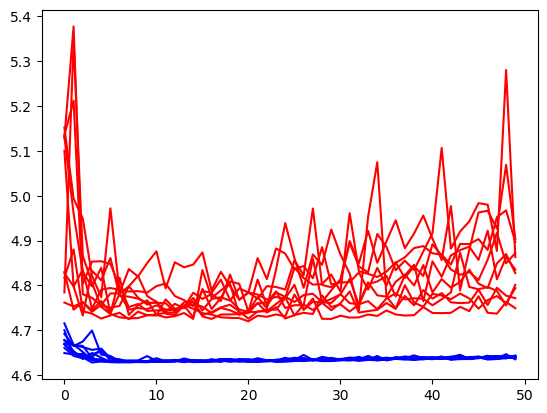

In [8]:
def run():
    # config 
    stationary = True
    repeats = 10
    n_batch = 16
    n_epochs = 250
    n_neurons = 10
    n_preds = 5
    # load in the dataset
    data = read_data('../../data/SPY_1993-01-29_2022-08-17.csv')
    # transforming data to be in the form I need
    data = add_features(data)
    data = data.dropna()
    raw_values = data.values
    undiffed = data.adj_close
    if stationary:
        data.adj_close = data.adj_close.diff(-1) * -1
    # transform into a supervised learning problem
    supervised = series_to_supervised(data, n_in=14, n_out=5, col_names=data.columns, indicies=data.index, preds=[4])
    supervised = supervised.drop(supervised.columns[-5:-1], axis=1)
    supervised_vals = supervised.values
    # split the data into train/test splits
    train, test = split_data(supervised_vals, .2)
    # rescale the data
    scaler, train_scaled, test_scaled = scale(train, test)
    
    # time to fit and evaluate the model
    train_trimmed = train_scaled[len(train_scaled)%16:]
    test_trimmed = test_scaled[:-(len(test_scaled) % 16)]
    for i in range(repeats):
        history = fit_lstm(train_trimmed, test_trimmed, raw_values, scaler, n_batch, n_epochs, n_neurons)
        plt.plot(history['train'], color='b')
        plt.plot(history['test'], color='r')
        print('%d) TrainingRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))
    plt.savefig('epochs_diagnostic.png')
    plt.show();
    
run()